In [ ]:
!pip install transformers pandas matplotlib seaborn


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch


In [ ]:
!pip install datasets transformers huggingface_hub tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
import torch
import csv
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
from datasets import load_dataset
from huggingface_hub import login
from google.colab import userdata  # Import userdata for Colab Secrets

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)

# Retrieve Hugging Face token from Colab Secrets Manager
huggingface_token = userdata.get('HF_TOKENV2')
if not huggingface_token:
    raise ValueError("Hugging Face token not found. Ensure 'HF_TOKENV2' is set in Colab Secrets.")

# Log in to Hugging Face
login(token=huggingface_token)

# Define the model
model_name = "tiiuae/falcon-7b-instruct"  # Falcon 7B Instruct

# Load tokenizer and model with authentication
tokenizer = AutoTokenizer.from_pretrained(model_name, token=huggingface_token)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # Automatically handle device placement
    torch_dtype=torch.float16,  # Use FP16 for efficient inference
    token=huggingface_token
)

# Load the dataset
dataset = load_dataset("fka/awesome-chatgpt-prompts")
prompts_df = dataset["train"].to_pandas()
prompts_list = list(prompts_df["prompt"][:5])

# Output file
output_file = "falcon_responses.csv"
file_exists = os.path.isfile(output_file)

# Open CSV file and write headers if needed
with open(output_file, mode="a", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    if not file_exists:
        writer.writerow(["prompt", "response"])

    # Process each prompt
    for prompt in tqdm(prompts_list, desc="Processing Prompts"):
        # Frame the instruction with explicit expectations
        instruction = f"""
        You are a helpful assistant. Please provide a detailed, structured, and accurate response to the following prompt:
        {prompt.strip()}
        """

        # Tokenize input
        inputs = tokenizer(instruction, return_tensors="pt").to(model.device)
        torch.manual_seed(SEED)

        # Generate text
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,  # Adjust response length
            temperature=0.4,     # Reduce randomness for deterministic outputs
            top_k=40,            # Use top-k sampling for diversity
            top_p=0.85,          # Use nucleus sampling for relevance
            no_repeat_ngram_size=3  # Avoid repetition in the output
        )

        # Decode generated tokens
        generated_tokens = outputs[0][inputs["input_ids"].shape[1]:]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()

        # Write prompt and response to the file
        writer.writerow([prompt, generated_text])

print(f"Falcon-generated responses saved to '{output_file}'.")


tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/339 [00:00<?, ?B/s]

prompts.csv:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/170 [00:00<?, ? examples/s]

Processing Prompts:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.85` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:No

Falcon-generated responses saved to 'falcon_responses.csv'.


In [ ]:
import os
import torch
import pandas as pd
import csv
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

SEED = 42
torch.manual_seed(SEED)

model_name = "microsoft/Phi-3.5-mini-instruct"  # Replace with another model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

prompts_df = pd.read_csv("hf://datasets/fka/awesome-chatgpt-prompts/prompts.csv")
prompts_list = prompts_df["prompt"][:5]

output_file = "generated_texts_comparison.csv"
file_exists = os.path.isfile(output_file)

# Process each prompt and generate text
with open(output_file, mode="a", newline="") as file:
    writer = csv.writer(file)

    if not file_exists:
        header = ["prompt", "response"]
        writer.writerow(header)

    for prompt in tqdm(prompts_list, desc="Processing Prompts"):
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        torch.manual_seed(SEED)

        # Generate text
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            no_repeat_ngram_size=3,
            temperature=0.7,
            top_k=50,
            top_p=0.9
        )

        generated_tokens = outputs[0][inputs["input_ids"].shape[1]:]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()

        writer.writerow([prompt, generated_text])

print(f"Generated texts saved to '{output_file}'.")


tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

Processing Prompts:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Processing Prompts: 100%|██████████| 5/5 [02:59<00:00, 35.91s/it]

Generated texts saved to 'generated_texts_comparison.csv'.


In [ ]:
import os
import torch
import csv
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm
from datasets import load_dataset

SEED = 42
torch.manual_seed(SEED)

model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

dataset = load_dataset("fka/awesome-chatgpt-prompts")
prompts_df = dataset["train"].to_pandas()
prompts_list = list(prompts_df["prompt"][:5])

output_file = "flan_t5_responses.csv"
file_exists = os.path.isfile(output_file)

with open(output_file, mode="a", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    if not file_exists:
        writer.writerow(["prompt", "response"])

    # Process each prompt
    for prompt in tqdm(prompts_list, desc="Processing Prompts"):

        instruction = f"""
        You are a helpful assistant. Please provide a detailed and well-structured response to the following prompt:
        {prompt.strip()}
        """

        inputs = tokenizer(instruction, return_tensors="pt", padding=True, truncation=True)
        torch.manual_seed(SEED)

        # Generate text
        outputs = model.generate(
            **inputs,
            max_new_tokens=800,
            temperature=0.4,
            top_k=40,
            top_p=0.85,
            no_repeat_ngram_size=3
        )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        writer.writerow([prompt, generated_text])

print(f"Flan-T5-generated responses saved to '{output_file}'.")


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Processing Prompts:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.85` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Processing Prompts: 100%|██████████| 5/5 [0

Flan-T5-generated responses saved to 'flan_t5_responses.csv'.


In [ ]:
import os
import torch
import csv
from transformers import AutoTokenizer, AutoModelForCausalLM

SEED = 42
torch.manual_seed(SEED)

model_name = "EleutherAI/gpt-neo-125M"

tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # Automatically handle device placement
    torch_dtype=torch.float16  # Use FP16 for efficient inference
)

specific_prompt = """
Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger.
The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract,
and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations
for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.
"""

instruction = f"{specific_prompt.strip()}"

inputs = tokenizer(instruction, return_tensors="pt", truncation=True, padding=True).to("cuda" if torch.cuda.is_available() else "cpu")

outputs = model.generate(
    **inputs,
    max_new_tokens=500,  # Adjust response length
    temperature=0.4,     # Reduce randomness for deterministic outputs
    top_k=40,            # Use top-k sampling for diversity
    top_p=0.85,          # Use nucleus sampling for relevance
    no_repeat_ngram_size=3  # Avoid repetition in the output
)

full_generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
response = full_generated_text.replace(specific_prompt.strip(), "").strip()

output_file = "gpt_neo_125M_cleaned_responses.csv"
with open(output_file, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["prompt", "response"])
    writer.writerow([specific_prompt, response])

print(f"Generated response saved to '{output_file}'.")


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated response saved to 'gpt_neo_125M_cleaned_responses.csv'.


In [ ]:
import os
import torch
import csv
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)

# Model and tokenizer setup
model_name = "EleutherAI/gpt-neo-125M"
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # Automatically handle device placement
    torch_dtype=torch.float16  # Use FP16 for efficient inference
)

# Load dataset and extract the first 5 prompts
dataset = load_dataset("fka/awesome-chatgpt-prompts")
prompts_df = dataset["train"].to_pandas()
prompts_list = list(prompts_df["prompt"][:5])  # First 5 prompts

# Define output CSV file
output_file = "gpt_neo_125M_responses.csv"
file_exists = os.path.isfile(output_file)

with open(output_file, mode="a", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    if not file_exists:
        writer.writerow(["prompt", "response"])

    # Process each prompt
    for prompt in tqdm(prompts_list, desc="Processing Prompts"):

        # Format the instruction
        instruction = f"{prompt.strip()}"

        # Tokenize and generate response
        device = "cuda" if torch.cuda.is_available() else "cpu"
        inputs = tokenizer(instruction, return_tensors="pt", truncation=True, padding=True).to(device)

        torch.manual_seed(SEED)

        # Generate model response
        outputs = model.generate(
            **inputs,
            max_new_tokens=600,  # Allow for longer responses
            temperature=0.7,     # Increase diversity slightly
            top_k=50,            # Increase the range of sampled tokens
            top_p=0.9,           # Increase probability-based sampling
            no_repeat_ngram_size=3,  # Prevent repetition
            repetition_penalty=1.2  # Penalize repetitive tokens
        )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        if generated_text.startswith(prompt.strip()):
            cleaned_response = generated_text[len(prompt.strip()):].strip()
        else:
            cleaned_response = generated_text

        writer.writerow([prompt, cleaned_response])

print(f"GPT-Neo-125M-generated responses saved to '{output_file}'.")

Processing Prompts: 100%|██████████| 5/5 [00:26<00:00,  5.28s/it]

GPT-Neo-125M-generated responses saved to 'gpt_neo_125M_responses.csv'.


In [ ]:
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

dataset = load_dataset("mteb/summeval")

data_split = dataset["test"][:3]

smoothing = SmoothingFunction().method1

bleu_scores = []
num_rows = len(data_split["human_summaries"])

for idx in range(num_rows):
    human_summary = data_split["human_summaries"][idx][0]
    machine_summary = data_split["machine_summaries"][idx][0]

    # Tokenize and compute BLEU score
    reference = [human_summary.split()]
    candidate = machine_summary.split()
    score = sentence_bleu(reference, candidate, smoothing_function=smoothing)
    bleu_scores.append({"Row": idx + 1, "BLEU Score": score})

# Print BLEU scores
for result in bleu_scores:
    print(f"Row {result['Row']}: BLEU Score = {result['BLEU Score']}")


README.md:   0%|          | 0.00/635 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

(…)-00000-of-00001-35901af5f6649399.parquet:   0%|          | 0.00/423k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Row 1: BLEU Score = 0.02260124130550866
Row 2: BLEU Score = 0.07774353802951435
Row 3: BLEU Score = 0.012332925950800428


In [ ]:
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

dataset = load_dataset("mteb/summeval")
entry = dataset['test'][0]

# Extract the first human summary and the first machine summary
human_summary = entry["human_summaries"][0]
machine_summary = entry["machine_summaries"][0]

# Tokenize the summaries
reference = [human_summary.split()]
candidate = machine_summary.split()

# Apply smoothing to avoid zero divisions for short texts
smoothing = SmoothingFunction().method1

# Compute BLEU score
bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing)

print("BLEU Score:", bleu_score)


BLEU Score: 0.02260124130550866


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')
machine_summaries = [
  "donald sterling , nba team last year . sterling 's wife sued for $ 2.6 million in gifts . sterling says he is the former female companion who has lost the . sterling has ordered v. stiviano to pay back $ 2.6 m in gifts after his wife sued . sterling also includes a $ 391 easter bunny costume , $ 299 and a $ 299 .",
  "donald sterling accused stiviano of targeting extremely wealthy older men . she claimed donald sterling used the couple 's money to buy stiviano a ferrari , two bentleys and a range rover . stiviano countered that there was nothing wrong with donald sterling giving her gifts .",
  "a los angeles judge has ordered v. stiviano to pay back more than $ 2.6 million in gifts after sterling 's wife sued her . -lrb- cnn -rrb- donald sterling 's racist remarks cost him an nba team last year . but now it 's his former female companion who has lost big . who is v. stiviano ? .",
  "donald sterling 's wife sued stiviano of targeting extremely wealthy older men . she claimed donald sterling used the couple 's money to buy stiviano a ferrari , bentleys and a range rover . stiviano 's gifts from donald sterling did n't just include uber-expensive items like luxury cars .",
  "donald sterling 's racist remarks cost him an nba team last year . but now it 's his former female companion who has lost big . a judge has ordered v. stiviano to pay back more than $ 2.6 million in gifts .",
  "rochelle `` shelly '' sterling accused stiviano of targeting extremely wealthy older men . she claimed donald sterling used the couple 's money to buy stiviano a ferrari . stiviano countered that there was nothing wrong with donald sterling giving her gifts .",
  "( cnn ) donald sterling 's racist remarks cost him an nba team last year . but now it 's his former female companion who has lost big . a los angeles judge has ordered v. stiviano to pay back more than $ 2.6 million in gifts after sterling 's wife sued her . in the lawsuit , rochelle \" shelly \" sterling accused stiviano of targeting extremely wealthy older men .",
  "a judge orders v. stiviano to pay back more than $2.6 million in gifts . she was sued by donald sterling's wife, rochelle \"shelly\" sterling . she accused stiviano of targeting extremely wealthy older men . stiviano countered that there was nothing wrong with sterling giving her gifts .",
  "Donald Sterling's racist remarks cost him an NBA team last year. But now it's his former female companion who has lost big.",
  "a los angeles judge orders v. stiviano to pay back more than $2.6 million in gifts . rochelle \"shelly\" sterling accused stiviano of targeting extremely wealthy older men . she claimed donald sterling used the couple's money to buy stiviano a ferrari, two bentleys and a range rover .",
  "a los angeles judge has ordered v. stiviano to pay back more than $ 2.6 million in gifts after sterling 's wife sued her . in the lawsuit , rochelle `` shelly '' sterling accused stiviano of targeting extremely wealthy older men . she claimed donald sterling used the couple 's money to buy stiviano a ferrari , two bentleys and a range rover , and that he helped her get a $ 1.8 million duplex .",
  "-lrb- cnn -rrb- donald sterling 's racist remarks cost him an nba team last year . but now it 's his former female companion who has lost big . a los angeles judge has ordered v. stiviano to pay back more than $ 2.6 million in gifts after sterling 's wife sued her .",
  "A judge orders V. Stiviano to pay back more than $ 2.6 million in gifts from Donald Sterling . Sterling 's wife sued her , saying she targeted wealthy older men . Shelly Sterling was thrilled with the court decision , her lawyer says . The gifts included a Ferrari , two Bentleys and a Range Rover .",
  "rochelle `` shelly '' sterling accused stiviano of targeting extremely wealthy older men . she claimed donald sterling used the couple 's money to buy stiviano a ferrari , two bentleys and a range rover . stiviano 's gifts from donald sterling did n't just include uber-expensive items like luxury cars .",
  "donald sterling 's racist remarks cost him an nba team last year . in the lawsuit , rochelle `` shelly '' sterling used the couple 's money to buy stiviano a ferrari , wealthy older men . shelly sterling 's gifts from donald sterling was $ 2.6 million in gifts .",
  "donald sterling 's remarks cost him an nba team last year . a los angeles judge has ordered v. stiviano to pay back more than $ 2.6 million . rochelle `` shelly '' sterling accused stiviano of targeting wealthy older men . stiviano says there was nothing wrong with donald sterling giving her gifts ."
]

human_summaries = [
  "V. Stiviano must pay back $2.6 million in gifts from Donald Sterling. Sterling's wife claimed the ex-Clippers used the couple's money for the gifts. The items included a Ferrari, two Bentleys and a Range Rover.",
  "A player for a team has been under scrunity for money being earned while injured. The NBA is not pleased with these outcomes and this player has caused lots of controversy.",
  "Donald Sterling lost his NBA team amid racist comments. His former companion is set to pay back over $2.6 million to Sterling's wife through lawsuit. The case has been considered a victory for the Sterling family.",
  "Donald Sterling cheated with a mistress, Stiviano, who was sued by Sterling's wife. The mistress was blamed for Sterling spending over $2.6 million on her and ordered to pay it all back.",
  "Donald Sterling's mistress will have to pay Sterling's wife for many lavish gifts that Sterling bought for her. V. Stiviano, the mistress, will have to pay pack $2,630,000 in restitution. Sterling made some racist remarks in regards to Instagram posts by V. Stiviano which led to the NBA banning Sterling from owning an NBA franchise.",
  "Donald Sterling's former lover, V. Stiviano, has been told to pay Sterling's wife more than 2.6 million dollars. Shelly Sterling says that Donald used the pair's money to purchase expensive gifts for Stiviano, including three cars and a duplex. Last year Donald Sterling made racist remarks and lost his NBA team, the Clippers.",
  "Donald Sterling lost a NBA franchise for his racist comments. The judge ordered Sterling's mistress, V Stiviano to pay $2.6 million dollars. The family of Sterling got back $2,630,000 from Stiviano.",
  "Donald Sterling lost an NBA team after he made racist remarks. Sterling was ordered by the Los Angeles judge to spend $2.6 million to pay back gifts. $2,630,000 was recovered by the Sterling family.",
  "Donald Sterling made racist remarks and ended up losing the NBA team that he owned. A Los Angeles judge also ordered Stiviano to return over $2.6 million dollars in gifts, due to a lawsuit by Sterling's wife. The Sterling family received $2,630,000 back from Sterling's former mistress, Stiviano.",
  "The racist remarks that were said by Doanld Sterling cost him his ownership of the Clippers. The NBA commissioner fined him $2.5 million and forced him to sell the team. Sterling's mistress, V Stiviano was ordered by an LA judge to pay back $2.6 million after Sterling's wife Shelly won a lawsuit against her. This was considered a victory by the attorney for Shelly.",
  "Donald Sterling is the former owner of NBA team The Los Angeles Clippers who lost his ownership rights following racist comments. Following a court decision, a Los Angeles judge ordered Sterling's former female companion, V. Stiviano, to pay back $2,630,000 that Sterling had spent on gifts for her to the Sterling family. This comes after a lawsuit filed by Sterling's wife."
]

from nltk.translate.bleu_score import corpus_bleu

# Tokenize the summaries
tokenized_machine_summaries = [m.lower().split() for m in machine_summaries]
tokenized_human_summaries = [h.lower().split() for h in human_summaries]

# In corpus_bleu, the references should be a list of lists of tokenized references for each hypothesis.
# Here we’ll treat all human summaries as references for each machine summary:
references = [tokenized_human_summaries for _ in tokenized_machine_summaries]

# Calculate the BLEU score
bleu_score = corpus_bleu(references, tokenized_machine_summaries)
print("BLEU Score:", bleu_score)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


BLEU Score: 0.1468745724370761


In [ ]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Define file paths for models and human references
files = {
    "GPT-Neo": "gpt_neo_125M_responses.csv",
    "Flan-T5": "flan_t5_responses.csv",
    "Falcon": "falcon_responses.csv",
    "Phi-3": "generated_texts_comparison.csv"
}
human_file = "human_generated.csv"

# Load human references, assigning a column name if none exist
human_data = pd.read_csv(human_file, header=None, names=["Reference_Text"])

# Function to clean and convert to string
def preprocess_data(data):
    return data.fillna("").astype(str)

# Function to compute BLEU scores for a single prompt
def compute_bleu_scores(human_references, model_outputs):
    smoothing_function = SmoothingFunction().method1
    bleu_scores = []
    for human, model in zip(human_references, model_outputs):
        reference = [human.split()]  # Tokenize reference
        candidate = model.split()   # Tokenize model output
        bleu = sentence_bleu(reference, candidate, smoothing_function=smoothing_function)
        bleu_scores.append(bleu)
    return bleu_scores

# Preprocess human references
human_references = preprocess_data(human_data["Reference_Text"].iloc[:5])

# Load model outputs and compute BLEU scores
results = {}
for model, path in files.items():
    model_data = pd.read_csv(path)
    # Preprocess model outputs
    model_outputs = preprocess_data(model_data['response'].iloc[:5])  # Replace 'response' with actual column name
    bleu_scores = compute_bleu_scores(human_references, model_outputs)
    results[model] = bleu_scores

# Display results
for model, scores in results.items():
    print(f"BLEU Scores for {model}: {scores}")


BLEU Scores for GPT-Neo: [0.0004557649204713771, 0.004261964076380075, 0, 0.0008819788496714594, 0.0022555993735920853]
BLEU Scores for Flan-T5: [0.004635487482440636, 0.001052770902985843, 0, 0.019090277826420414, 0.012897742882522783]
BLEU Scores for Falcon: [0.034042541540929575, 0.0068763801555248106, 0, 0.005641822153183602, 0.0021327661547589525]
BLEU Scores for Phi-3: [0.012326322532740139, 0.007827104312739527, 0.0007648602026099222, 0.0006990932135762832, 0]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# BLEU scores for each model
bleu_scores = {
    "GPT-Neo": [0.0004519152701111947, 0.0026420529669883264, 0, 0.002594445031287883, 0.0013464255988130855],
    "Flan-T5": [0.004635487482440636, 0.001052770902985843, 0, 0.019090277826420414, 0.012897742882522783],
    "Falcon": [0.034042541540929575, 0.003383709657059338, 0, 0.005641822153183602, 0.0021327661547589525],
    "Phi-3": [0.012326322532740139, 0.007827104312739527, 0.0007648602026099222, 0.0006990932135762832, 0]
}

# Benchmark BLEU score
benchmark = 0.1468745724370761

# Calculate average BLEU scores for each model
average_bleu_scores = {model: np.mean(scores) for model, scores in bleu_scores.items()}

plt.figure(figsize=(10, 6))

# Bar chart for average BLEU scores
models = list(average_bleu_scores.keys())
scores = list(average_bleu_scores.values())
plt.bar(models, scores, color='skyblue', label='Average BLEU Score')

# Benchmark line
plt.axhline(y=benchmark, color='red', linestyle='--', label=f'Benchmark BLEU Score ({benchmark:.3f})')

# Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Average BLEU Score', fontsize=12)
plt.title('Comparison of Model BLEU Scores Against Benchmark', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add data labels
for i, score in enumerate(scores):
    plt.text(i, score + 0.001, f"{score:.3f}", ha='center', fontsize=10)

# Add legend
plt.legend(fontsize=10)

# Show plot
plt.tight_layout()
plt.show()



Summary for GPT-Neo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   prompt    5 non-null      object
 1   response  5 non-null      object
dtypes: object(2)
memory usage: 208.0+ bytes
None
                                                   prompt  \
count                                                   5   
unique                                                  5   
top     Imagine you are an experienced Ethereum develo...   
freq                                                    1   

                                                 response  
count                                                   5  
unique                                                  5  
top     The goal of this project is to create a smart-...  
freq                                                    1  
Sample rows from GPT-Neo:
                                            

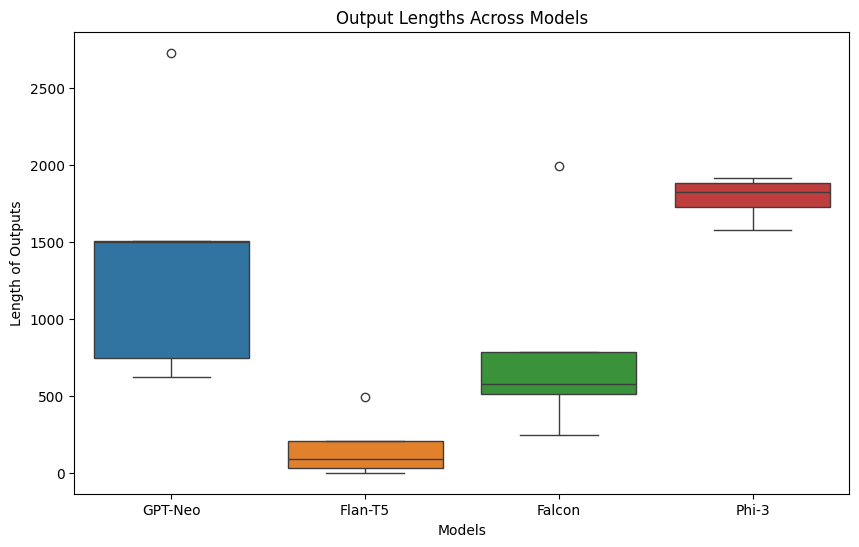


Unique Response Counts per Model:
{'GPT-Neo': 5, 'Flan-T5': 5, 'Falcon': 5, 'Phi-3': 4}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
files = {
    "GPT-Neo": "gpt_neo_125M_responses.csv",
    "Flan-T5": "flan_t5_responses.csv",
    "Falcon": "falcon_responses.csv",
    "Phi-3": "generated_texts_comparison.csv"
}

# Load the data
dataframes = {name: pd.read_csv(path) for name, path in files.items()}

# Display basic information
def display_summary(df, model_name):
    print(f"\nSummary for {model_name}:")
    print(df.info())
    print(df.describe())
    print(f"Sample rows from {model_name}:\n", df.head())

# Explore each DataFrame
for model, df in dataframes.items():
    display_summary(df, model)

# EDA: Compare output lengths using the 'response' column
lengths = {model: df['response'].dropna().apply(len) for model, df in dataframes.items()}

# Combine lengths into a single DataFrame
lengths_df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in lengths.items()]))

# Plot output lengths
plt.figure(figsize=(10, 6))
sns.boxplot(data=lengths_df)
plt.title("Output Lengths Across Models")
plt.xlabel("Models")
plt.ylabel("Length of Outputs")
plt.show()

# Additional Analysis: Unique responses
unique_counts = {model: df['response'].nunique() for model, df in dataframes.items()}
print("\nUnique Response Counts per Model:")
print(unique_counts)

# Save a summary of unique responses to CSV
summary_df = pd.DataFrame(list(unique_counts.items()), columns=["Model", "Unique Responses"])
summary_df.to_csv("unique_responses_summary.csv", index=False)
